In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
muons = np.load("/media/tdhttt/ds/muon/images/images.npy")
print(muons.shape)

labels = np.load("/media/tdhttt/ds/muon/images/labels.npy")
print(labels.shape)

sigi = np.where(labels==1)
bgi = np.where(labels==0)

N = 249950
sig = muons[sigi][:N]
bg = muons[bgi][:N]

print(sig.shape)
print(bg.shape)

(499970, 32, 32)
(499970,)
(249950, 32, 32)
(249950, 32, 32)


In [4]:
def mix_data(br, sig, bg):
    Ns = int(N*(1-br))
    Nb = N - Ns
    sig_yn = np.concatenate((np.ones(Ns), np.zeros(Nb)))
    bg_yn = np.concatenate((np.ones(Nb), np.zeros(Ns)))

    sig_y = np.column_stack((np.ones(N), sig_yn))
    bg_y = np.column_stack((np.zeros(N), bg_yn))


    X = np.concatenate((sig,bg))
    Y = np.concatenate((sig_y,bg_y))

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)
    return x_train, x_val, x_test, y_train, y_val, y_test

In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [6]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.special import expit

In [7]:
input_img=Input(shape=(32, 32, 1))
layer=input_img
layer=Conv2D(128, kernel_size=(3, 3),activation='relu',padding='same')(layer)
layer=MaxPooling2D(pool_size=(2, 2),padding='same')(layer)
layer=Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same')(layer)
layer=MaxPooling2D(pool_size=(2, 2),padding='same')(layer)
layer=Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same')(layer)

layer=Flatten()(layer)
layer=Dense(32, activation='relu')(layer)
layer=Dense(6, activation='relu')(layer)
layer=Dense(1, activation='sigmoid')(layer)

model=Model(input_img ,layer)
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam())
model.summary()
model.save_weights('cnnbase.h5')

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                           patience=8, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [9]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
def plot_al(history,aorl):
    plt.figure()
    plt.plot(history.history[aorl])
    plt.plot(history.history['val_'+aorl])
    plt.title((" Accuracy" if aorl=="acc" else " Loss"))
    plt.ylabel(aorl)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def roc(true,pred,b,ax):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(true, pred)
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    print(roc_auc)
    ax.plot(fpr[1], tpr[1], label='CWoLa b={:.1f}({:.3f})'.format(b,roc_auc[0]) 
             if b else "Supervised({:.3f})".format(roc_auc[0]))
    
    return roc_auc[0]

In [16]:
def train_model(model, x_train, y_train, x_val, y_val, x_test, y_test, ax, br=0):
    model.load_weights('cnnbase.h5')
    history = model.fit(x_train, y_train, epochs=20, batch_size=128, 
                    validation_data=(x_val, y_val),verbose=1,
                    callbacks=callbacks)
    y_hat = model.predict(x_test)
    y_hat = np.reshape(y_hat,(y_hat.shape[0]))
    if br >= 0.5:
        y_hat = 1-y_hat
    aucx = roc(y_test, y_hat, br, ax)
    model.save_weights(('cwola_'+ str(br) if br else 'supervised') +'cnnbase' +'_20e_128b_'+ str(aucx) +'.h5')
    return aucx, y_hat, history

Bg/All in the mixed sample is: 0
Epoch 1/20
2734/2734 [==============================] - 18s 7ms/step - loss: 0.5213 - val_loss: 0.5036
Epoch 2/20
2734/2734 [==============================] - 18s 7ms/step - loss: 0.4949 - val_loss: 0.4899
Epoch 3/20
2734/2734 [==============================] - 18s 7ms/step - loss: 0.4862 - val_loss: 0.5010
Epoch 4/20
2734/2734 [==============================] - 18s 7ms/step - loss: 0.4817 - val_loss: 0.4864
Epoch 5/20
2734/2734 [==============================] - 18s 7ms/step - loss: 0.4788 - val_loss: 0.4850
Epoch 6/20
2734/2734 [==============================] - 18s 7ms/step - loss: 0.4757 - val_loss: 0.4846
Epoch 7/20
2734/2734 [==============================] - 18s 7ms/step - loss: 0.4727 - val_loss: 0.4870
Epoch 8/20
2734/2734 [==============================] - 18s 7ms/step - loss: 0.4691 - val_loss: 0.4878
Epoch 9/20
2734/2734 [==============================] - 18s 7ms/step - loss: 0.4657 - val_loss: 0.4909
Epoch 10/20
2734/2734 [=================

{0: 0.30166212551304566, 1: 0.30166212551304566}
Done!


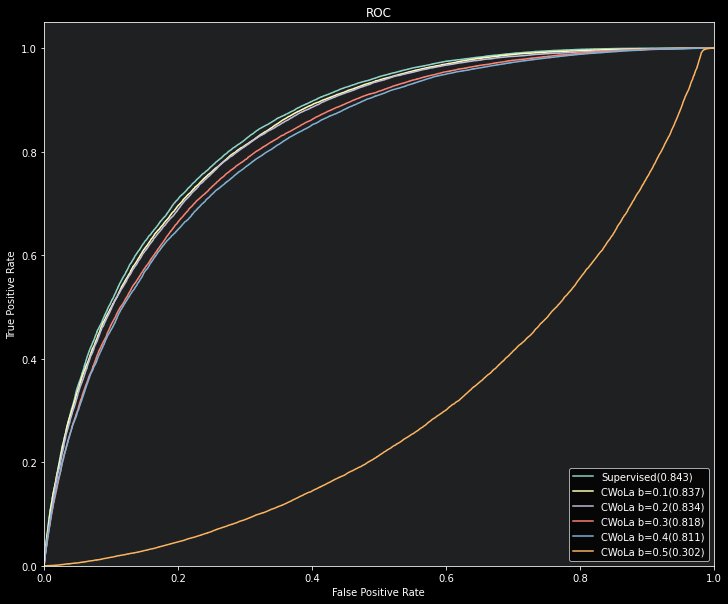

In [17]:
i = 0
aucs = []
y_hats = []
historys = []
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(12,10))
ax.set_facecolor('#1e2021')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC')

while True:
    print("Bg/All in the mixed sample is:",i)
    x_train, x_val, x_test, y_train, y_val, y_test = mix_data(i, sig, bg)
    aucx, y_hatx, historyx = train_model(model, x_train, y_train[:,1], x_val, y_val[:,1], 
                             x_test, y_test[:,0], ax, i)
    aucs.append(aucx)
    y_hats.append(y_hatx)
    historys.append(historyx)

    i += 0.1
    if i >= 0.6:
        print('Done!')
        break
        
ax.legend(loc='lower right')
plt.show()